# [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course)

## Install necessary packages

In [1]:
# !conda install numpy pandas matplotlib seaborn missingno scikit-learn pandas_profiling -y

In [2]:
# !conda install -c conda-forge xgboost -y

## Import necessary packages

In [3]:
import numpy as np
import pandas as pd

from pandas.api.types import CategoricalDtype

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

## Read in data

In [4]:
train_file_path = "./../../data/hpc_train.csv"
test_file_path = "./../../data/hpc_test.csv"

In [5]:
pd.options.display.max_columns = None

In [6]:
train = pd.read_csv(train_file_path, index_col="Id")
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [7]:
test = pd.read_csv(test_file_path, index_col="Id")

In [8]:
train.MSSubClass = train.MSSubClass.astype("category")

train.OverallQual = train.OverallQual.astype(
    CategoricalDtype(categories=list(range(1, 11)), ordered=True)
)

train.OverallCond = train.OverallCond.astype(
    CategoricalDtype(categories=list(range(1, 11)), ordered=True)
)

In [9]:
train.YearBuilt = pd.to_datetime(train.YearBuilt, format="%Y")

train.YearRemodAdd = pd.to_datetime(train.YearRemodAdd, format="%Y")

train.GarageYrBlt = pd.to_datetime(train.GarageYrBlt, format="%Y")

train.MoSold = pd.to_datetime(train.MoSold, format="%M")
train.YrSold = pd.to_datetime(train.YrSold, format="%Y")

In [10]:
yes_no_map = {"Y": True, "N": False}

train.CentralAir = train.CentralAir.map(yes_no_map).astype("bool")

## Exploratory Data Analysis


### Missing values

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MSSubClass     1460 non-null   category      
 1   MSZoning       1460 non-null   object        
 2   LotFrontage    1201 non-null   float64       
 3   LotArea        1460 non-null   int64         
 4   Street         1460 non-null   object        
 5   Alley          91 non-null     object        
 6   LotShape       1460 non-null   object        
 7   LandContour    1460 non-null   object        
 8   Utilities      1460 non-null   object        
 9   LotConfig      1460 non-null   object        
 10  LandSlope      1460 non-null   object        
 11  Neighborhood   1460 non-null   object        
 12  Condition1     1460 non-null   object        
 13  Condition2     1460 non-null   object        
 14  BldgType       1460 non-null   object        
 15  HouseStyle     1460 n

In [12]:
cat_col_names_with_na = []
cat_col_names_without_na = []
for col_name in train.select_dtypes(include=["object"]):
    print(f"Name: {col_name}\tdtype: {train[col_name].dtype}")
    print(f"nunique: {train[col_name].nunique()}")
    missing_count = train[col_name].isnull().sum()
    count = train[col_name].count()
    if missing_count:
        cat_col_names_with_na.append(col_name)
        print(
            f"Missing: {missing_count} / {count} -> {missing_count/(missing_count + count)*100}% "
        )
    else:
        cat_col_names_without_na.append(col_name)
    display(train[col_name].value_counts(sort=False))

    print("-" * 30, "\n")

Name: MSZoning	dtype: object
nunique: 5


C (all)      10
RH           16
RM          218
RL         1151
FV           65
Name: MSZoning, dtype: int64

------------------------------ 

Name: Street	dtype: object
nunique: 2


Pave    1454
Grvl       6
Name: Street, dtype: int64

------------------------------ 

Name: Alley	dtype: object
nunique: 2
Missing: 1369 / 91 -> 93.76712328767123% 


Pave    41
Grvl    50
Name: Alley, dtype: int64

------------------------------ 

Name: LotShape	dtype: object
nunique: 4


Reg    925
IR3     10
IR2     41
IR1    484
Name: LotShape, dtype: int64

------------------------------ 

Name: LandContour	dtype: object
nunique: 4


HLS      50
Low      36
Bnk      63
Lvl    1311
Name: LandContour, dtype: int64

------------------------------ 

Name: Utilities	dtype: object
nunique: 2


NoSeWa       1
AllPub    1459
Name: Utilities, dtype: int64

------------------------------ 

Name: LotConfig	dtype: object
nunique: 5


Corner      263
CulDSac      94
FR2          47
Inside     1052
FR3           4
Name: LotConfig, dtype: int64

------------------------------ 

Name: LandSlope	dtype: object
nunique: 3


Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

------------------------------ 

Name: Neighborhood	dtype: object
nunique: 25


NoRidge     41
NAmes      225
MeadowV     17
Mitchel     49
Sawyer      74
Veenker     11
SawyerW     59
Edwards    100
NWAmes      73
ClearCr     28
OldTown    113
Timber      38
IDOTRR      37
Blueste      2
BrDale      16
StoneBr     25
BrkSide     58
Crawfor     51
NPkVill      9
NridgHt     77
Somerst     86
Blmngtn     17
SWISU       25
Gilbert     79
CollgCr    150
Name: Neighborhood, dtype: int64

------------------------------ 

Name: Condition1	dtype: object
nunique: 9


PosA         8
RRAn        26
Artery      48
Feedr       81
Norm      1260
RRAe        11
PosN        19
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

------------------------------ 

Name: Condition2	dtype: object
nunique: 8


PosA         1
RRAn         1
Artery       2
Feedr        6
Norm      1445
RRAe         1
PosN         2
RRNn         2
Name: Condition2, dtype: int64

------------------------------ 

Name: BldgType	dtype: object
nunique: 5


Duplex      52
1Fam      1220
Twnhs       43
TwnhsE     114
2fmCon      31
Name: BldgType, dtype: int64

------------------------------ 

Name: HouseStyle	dtype: object
nunique: 8


1.5Fin    154
2Story    445
1Story    726
SFoyer     37
SLvl       65
2.5Unf     11
1.5Unf     14
2.5Fin      8
Name: HouseStyle, dtype: int64

------------------------------ 

Name: RoofStyle	dtype: object
nunique: 6


Gable      1141
Gambrel      11
Flat         13
Shed          2
Hip         286
Mansard       7
Name: RoofStyle, dtype: int64

------------------------------ 

Name: RoofMatl	dtype: object
nunique: 8


ClyTile       1
Metal         1
Tar&Grv      11
CompShg    1434
Membran       1
Roll          1
WdShngl       6
WdShake       5
Name: RoofMatl, dtype: int64

------------------------------ 

Name: Exterior1st	dtype: object
nunique: 15


ImStucc      1
HdBoard    222
MetalSd    220
AsbShng     20
Wd Sdng    206
BrkFace     50
CBlock       1
Plywood    108
AsphShn      1
VinylSd    515
Stucco      25
Stone        2
WdShing     26
CemntBd     61
BrkComm      2
Name: Exterior1st, dtype: int64

------------------------------ 

Name: Exterior2nd	dtype: object
nunique: 16


ImStucc     10
HdBoard    207
MetalSd    214
AsbShng     20
Wd Sdng    197
BrkFace     25
Brk Cmn      7
CBlock       1
Plywood    142
AsphShn      3
Wd Shng     38
VinylSd    504
Stucco      26
Other        1
Stone        5
CmentBd     60
Name: Exterior2nd, dtype: int64

------------------------------ 

Name: MasVnrType	dtype: object
nunique: 4
Missing: 8 / 1452 -> 0.547945205479452% 


BrkFace    445
Stone      128
BrkCmn      15
None       864
Name: MasVnrType, dtype: int64

------------------------------ 

Name: ExterQual	dtype: object
nunique: 4


Fa     14
Gd    488
TA    906
Ex     52
Name: ExterQual, dtype: int64

------------------------------ 

Name: ExterCond	dtype: object
nunique: 5


Fa      28
Gd     146
TA    1282
Ex       3
Po       1
Name: ExterCond, dtype: int64

------------------------------ 

Name: Foundation	dtype: object
nunique: 6


CBlock    634
BrkTil    146
Slab       24
Wood        3
PConc     647
Stone       6
Name: Foundation, dtype: int64

------------------------------ 

Name: BsmtQual	dtype: object
nunique: 4
Missing: 37 / 1423 -> 2.5342465753424657% 


Fa     35
Gd    618
TA    649
Ex    121
Name: BsmtQual, dtype: int64

------------------------------ 

Name: BsmtCond	dtype: object
nunique: 4
Missing: 37 / 1423 -> 2.5342465753424657% 


Fa      45
Gd      65
TA    1311
Po       2
Name: BsmtCond, dtype: int64

------------------------------ 

Name: BsmtExposure	dtype: object
nunique: 4
Missing: 38 / 1422 -> 2.6027397260273974% 


Gd    134
Mn    114
Av    221
No    953
Name: BsmtExposure, dtype: int64

------------------------------ 

Name: BsmtFinType1	dtype: object
nunique: 6
Missing: 37 / 1423 -> 2.5342465753424657% 


Unf    430
Rec    133
GLQ    418
LwQ     74
ALQ    220
BLQ    148
Name: BsmtFinType1, dtype: int64

------------------------------ 

Name: BsmtFinType2	dtype: object
nunique: 6
Missing: 38 / 1422 -> 2.6027397260273974% 


Unf    1256
Rec      54
GLQ      14
LwQ      46
ALQ      19
BLQ      33
Name: BsmtFinType2, dtype: int64

------------------------------ 

Name: Heating	dtype: object
nunique: 6


Wall        4
GasA     1428
GasW       18
Grav        7
OthW        2
Floor       1
Name: Heating, dtype: int64

------------------------------ 

Name: HeatingQC	dtype: object
nunique: 5


Fa     49
Gd    241
TA    428
Ex    741
Po      1
Name: HeatingQC, dtype: int64

------------------------------ 

Name: Electrical	dtype: object
nunique: 5
Missing: 1 / 1459 -> 0.0684931506849315% 


FuseP       3
FuseA      94
Mix         1
FuseF      27
SBrkr    1334
Name: Electrical, dtype: int64

------------------------------ 

Name: KitchenQual	dtype: object
nunique: 4


Fa     39
Gd    586
TA    735
Ex    100
Name: KitchenQual, dtype: int64

------------------------------ 

Name: Functional	dtype: object
nunique: 7


Min2      34
Min1      31
Maj1      14
Maj2       5
Mod       15
Typ     1360
Sev        1
Name: Functional, dtype: int64

------------------------------ 

Name: FireplaceQu	dtype: object
nunique: 5
Missing: 690 / 770 -> 47.26027397260274% 


Fa     33
Gd    380
TA    313
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

------------------------------ 

Name: GarageType	dtype: object
nunique: 6
Missing: 81 / 1379 -> 5.5479452054794525% 


CarPort      9
Basment     19
Attchd     870
2Types       6
Detchd     387
BuiltIn     88
Name: GarageType, dtype: int64

------------------------------ 

Name: GarageFinish	dtype: object
nunique: 3
Missing: 81 / 1379 -> 5.5479452054794525% 


Fin    352
Unf    605
RFn    422
Name: GarageFinish, dtype: int64

------------------------------ 

Name: GarageQual	dtype: object
nunique: 5
Missing: 81 / 1379 -> 5.5479452054794525% 


Fa      48
Gd      14
TA    1311
Ex       3
Po       3
Name: GarageQual, dtype: int64

------------------------------ 

Name: GarageCond	dtype: object
nunique: 5
Missing: 81 / 1379 -> 5.5479452054794525% 


Fa      35
Gd       9
TA    1326
Ex       2
Po       7
Name: GarageCond, dtype: int64

------------------------------ 

Name: PavedDrive	dtype: object
nunique: 3


N      90
Y    1340
P      30
Name: PavedDrive, dtype: int64

------------------------------ 

Name: PoolQC	dtype: object
nunique: 3
Missing: 1453 / 7 -> 99.52054794520548% 


Fa    2
Gd    3
Ex    2
Name: PoolQC, dtype: int64

------------------------------ 

Name: Fence	dtype: object
nunique: 4
Missing: 1179 / 281 -> 80.75342465753424% 


GdPrv     59
GdWo      54
MnWw      11
MnPrv    157
Name: Fence, dtype: int64

------------------------------ 

Name: MiscFeature	dtype: object
nunique: 4
Missing: 1406 / 54 -> 96.30136986301369% 


Shed    49
TenC     1
Gar2     2
Othr     2
Name: MiscFeature, dtype: int64

------------------------------ 

Name: SaleType	dtype: object
nunique: 9


Oth         3
CWD         4
WD       1267
Con         2
New       122
ConLw       5
ConLI       5
COD        43
ConLD       9
Name: SaleType, dtype: int64

------------------------------ 

Name: SaleCondition	dtype: object
nunique: 6


Abnorml     101
Alloca       12
Normal     1198
Family       20
AdjLand       4
Partial     125
Name: SaleCondition, dtype: int64

------------------------------ 



In [13]:
cat_col_names_without_na

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MSSubClass     1460 non-null   category      
 1   MSZoning       1460 non-null   object        
 2   LotFrontage    1201 non-null   float64       
 3   LotArea        1460 non-null   int64         
 4   Street         1460 non-null   object        
 5   Alley          91 non-null     object        
 6   LotShape       1460 non-null   object        
 7   LandContour    1460 non-null   object        
 8   Utilities      1460 non-null   object        
 9   LotConfig      1460 non-null   object        
 10  LandSlope      1460 non-null   object        
 11  Neighborhood   1460 non-null   object        
 12  Condition1     1460 non-null   object        
 13  Condition2     1460 non-null   object        
 14  BldgType       1460 non-null   object        
 15  HouseStyle     1460 n

In [15]:
cat_col_names_with_na

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [16]:
train.Alley.fillna("NA", inplace=True)
train.BsmtQual.fillna("NA", inplace=True)
train.BsmtCond.fillna("NA", inplace=True)
train.BsmtExposure.fillna("NA", inplace=True)
train.BsmtFinType1.fillna("NA", inplace=True)
train.BsmtFinType2.fillna("NA", inplace=True)
train.FireplaceQu.fillna("NA", inplace=True)
train.GarageType.fillna("NA", inplace=True)
train.GarageFinish.fillna("NA", inplace=True)
train.GarageQual.fillna("NA", inplace=True)
train.GarageCond.fillna("NA", inplace=True)
train.PoolQC.fillna("NA", inplace=True)
train.Fence.fillna("NA", inplace=True)
train.MiscFeature.fillna("NA", inplace=True)

In [17]:
train.MasVnrType.fillna(train.MasVnrType.mode()[0], inplace=True)

train.Electrical.fillna(train.Electrical.mode()[0], inplace=True)

### Data types

#### object -> categorical

In [18]:
train.Exterior1st.unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [19]:
train.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [20]:
train.Exterior2nd.replace("Brk Cmn", "BrkComm", inplace=True)
train.Exterior2nd.replace("Wd Shng", "Wd Sdng", inplace=True)
train.Exterior2nd.replace("Wd Shng", "Wd Sdng", inplace=True)
train.Exterior2nd.replace("CmentBd", "CemntBd", inplace=True)

In [21]:
set(train.Exterior1st.unique()) - set(train.Exterior2nd.unique())

{'WdShing'}

In [22]:
set(train.Exterior2nd.unique()) - set(train.Exterior1st.unique())

{'Other'}

In [23]:
Exterior_cat = CategoricalDtype(
    categories=train.Exterior1st.unique().tolist() + ["Other", "PreCast"], ordered=False
)
Exterior_cat

CategoricalDtype(categories=['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace',
                  'WdShing', 'CemntBd', 'Plywood', 'AsbShng', 'Stucco',
                  'BrkComm', 'AsphShn', 'Stone', 'ImStucc', 'CBlock', 'Other',
                  'PreCast'],
, ordered=False)

In [24]:
train.MSZoning = train.MSZoning.astype(
    CategoricalDtype(
        categories=["A", "C (all)", "FV", "I", "RH", "RL", "RP", "RM"], ordered=False
    )
)

train.MSSubClass = train.MSSubClass.astype(
    CategoricalDtype(
        categories=[
            20,
            30,
            40,
            45,
            50,
            60,
            70,
            75,
            80,
            85,
            90,
            120,
            150,
            160,
            180,
            190,
        ],
        ordered=False,
    )
)

train.Street = train.Street.astype("category")

train.Alley = train.Alley.astype("category")

train.LotShape = train.LotShape.astype("category")

train.LandContour = train.LandContour.astype("category")

train.Utilities = train.Utilities.astype(
    CategoricalDtype(categories=["ELO", "NoSeWa", "NoSewr", "AllPub"], ordered=True)
)

train.LotConfig = train.LotConfig.astype("category")

train.LandSlope = train.LandSlope.astype("category")

train.Neighborhood = train.Neighborhood.astype("category")

train.Condition1 = train.Condition1.astype("category")

train.Condition2 = train.Condition2.astype("category")

train.BldgType = train.BldgType.astype("category")

train.HouseStyle = train.HouseStyle.astype("category")

train.RoofStyle = train.RoofStyle.astype("category")

train.RoofMatl = train.RoofMatl.astype("category")

Exterior_cat = CategoricalDtype(
    categories=train.Exterior1st.unique().tolist() + ["Other", "PreCast"], ordered=False
)
train.Exterior1st = train.Exterior1st.astype(Exterior_cat)
train.Exterior2nd = train.Exterior2nd.astype(Exterior_cat)

MasVnrType_cat = CategoricalDtype(
    categories=train.MasVnrType.unique().tolist() + ["CBlock"], ordered=False
)
train.MasVnrType = train.MasVnrType.astype(MasVnrType_cat)

Exter_cat = CategoricalDtype(categories=["Po", "Fa", "TA", "Gd", "Ex"], ordered=True)
train.ExterQual = train.ExterQual.astype(Exter_cat)
train.ExterCond = train.ExterQual.astype(Exter_cat)
train.HeatingQC = train.HeatingQC.astype(Exter_cat)
train.KitchenQual = train.KitchenQual.astype(Exter_cat)


# TODO: what is the best - no or something?
Bsmt_cat = CategoricalDtype(
    categories=["NA", "Po", "Fa", "TA", "Gd", "Ex"], ordered=True
)
train.BsmtQual = train.BsmtQual.astype(Bsmt_cat)
train.BsmtCond = train.BsmtCond.astype(Bsmt_cat)
train.FireplaceQu = train.FireplaceQu.astype(Bsmt_cat)
train.GarageQual = train.GarageQual.astype(Bsmt_cat)
train.GarageCond = train.GarageCond.astype(Bsmt_cat)
train.PoolQC = train.PoolQC.astype(Bsmt_cat)


train.Foundation = train.Foundation.astype("category")

train.BsmtExposure = train.BsmtExposure.astype("category")

Bsmt_fin = CategoricalDtype(
    categories=["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], ordered=True
)
train.BsmtFinType1 = train.BsmtFinType1.astype(Bsmt_fin)
train.BsmtFinType2 = train.BsmtFinType2.astype(Bsmt_fin)


train.Heating = train.Heating.astype("category")

Electrical_cat = CategoricalDtype(
    categories=["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"], ordered=True
)
train.Electrical = train.Electrical.astype(Electrical_cat)

Functional_cat = CategoricalDtype(
    categories=["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ordered=True,
)
train.Functional = train.Functional.astype(Functional_cat)

# ordered?
train.GarageType = train.GarageType.astype("category")

GarageFinish_cat = CategoricalDtype(
    categories=["NA", "Unf", "RFn", "Fin"], ordered=True
)
train.GarageFinish = train.GarageFinish.astype(GarageFinish_cat)

PavedDrive_cat = CategoricalDtype(categories=["N", "P", "Y"], ordered=True)
train.PavedDrive = train.PavedDrive.astype(PavedDrive_cat)

PavedDrive_cat = CategoricalDtype(
    categories=["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"], ordered=True
)
train.Fence = train.Fence.astype(PavedDrive_cat)

train.MiscFeature = train.MiscFeature.astype("category")

train.SaleType = train.SaleType.astype("category")

train.SaleCondition = train.SaleCondition.astype("category")

In [25]:
train.select_dtypes(exclude=["category", "number", "datetime", "bool"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Empty DataFrame

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   MSSubClass     1460 non-null   category      
 1   MSZoning       1460 non-null   category      
 2   LotFrontage    1201 non-null   float64       
 3   LotArea        1460 non-null   int64         
 4   Street         1460 non-null   category      
 5   Alley          1460 non-null   category      
 6   LotShape       1460 non-null   category      
 7   LandContour    1460 non-null   category      
 8   Utilities      1460 non-null   category      
 9   LotConfig      1460 non-null   category      
 10  LandSlope      1460 non-null   category      
 11  Neighborhood   1460 non-null   category      
 12  Condition1     1460 non-null   category      
 13  Condition2     1460 non-null   category      
 14  BldgType       1460 non-null   category      
 15  HouseStyle     1460 n

In [37]:
pd.set_option("display.max_rows", 100)

train.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

<AxesSubplot:>

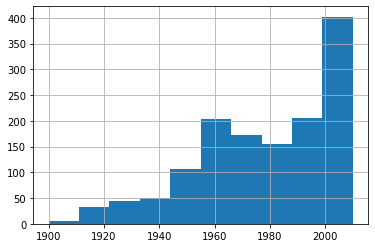

In [45]:
train.GarageYrBlt.hist()

<AxesSubplot:ylabel='Density'>

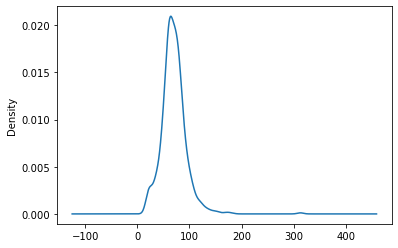

In [54]:
train.LotFrontage.plot.kde()

<AxesSubplot:>

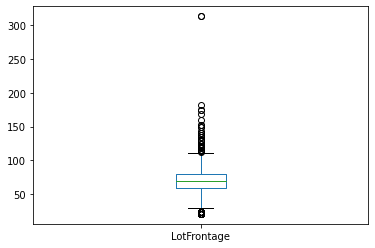

In [46]:
train.LotFrontage.plot.box()

In [42]:
import sklearn
import sklearn.impute

In [49]:
# strategy: mean, median, most_frequent, constant
imp_median = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy="median")
imp_median

SimpleImputer(strategy='median')

In [51]:
LotFrontage_imp = pd.DataFrame(
    imp_median.fit_transform(train[["LotFrontage"]]), columns=[train.LotFrontage.name]
)
LotFrontage_imp

,LotFrontage
0,65.0
1,80.0
2,68.0
3,60.0
4,84.0
...,...
1455,62.0
1456,85.0
1457,66.0
1458,68.0


<AxesSubplot:ylabel='Density'>

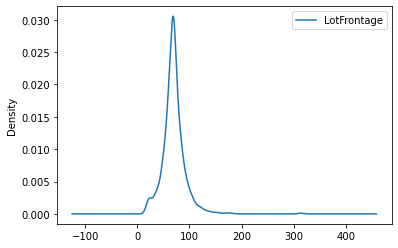

In [55]:
LotFrontage_imp.plot.kde()

In [56]:
train.LotFrontage = LotFrontage_imp

In [57]:
# strategy: mean, median, most_frequent, constant
imp_frequent = sklearn.impute.SimpleImputer(
    missing_values=np.nan, strategy="most_frequent"
)
imp_frequent

SimpleImputer(strategy='most_frequent')

In [58]:
GarageYrBlt_imp = pd.DataFrame(
    imp_median.fit_transform(train[["GarageYrBlt"]]), columns=[train.GarageYrBlt.name]
)
GarageYrBlt_imp

,GarageYrBlt
0,1.041379e+18
1,1.893024e+17
2,9.783072e+17
3,8.836128e+17
4,9.466848e+17
...,...
1455,9.151488e+17
1456,2.524608e+17
1457,-9.151488e+17
1458,-6.311520e+17


In [59]:
train.GarageYrBlt = GarageYrBlt_imp

<AxesSubplot:>

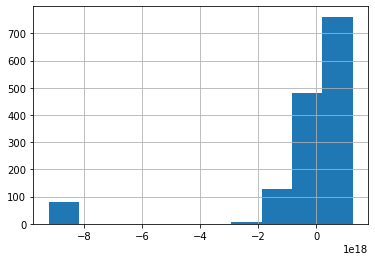

In [60]:
train.GarageYrBlt.hist()